In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from math import floor

## Helper functions

In [17]:
# get_img_intensity is a helper function to obtain the image intensity of an image 
# at a given coordinate if it exists
def get_img_intensity(img,x,y):
    assert len(img.shape)==2 # Checking if image shape is 2D
    # Checking if x and y are integers
    assert isinstance(x,int) 
    assert isinstance(y,int)
    if x<0 or x>=img.shape[0] or y<0 or y>=img.shape[1]:
        return 0
    else:
        return img[x,y]

# get_bilinear_interpolation_intensity takes source_image, x and y coordinates(possibly in decimals)
# and calculates intensity using Bilinear Interpolation from the image
def get_bilinear_interpolation_intensity(img_source,xs,ys):
    assert len(img_source.shape)==2
    xsd,ysd = int(floor(xs)),int(floor(ys))
    a,b = xs - xsd, ys - ysd
    return (1-a)*(1-b)*get_img_intensity(img_source,xsd,ysd) + \
           (a)*(1-b)*get_img_intensity(img_source,xsd+1,ysd) + \
           (1-a)*(b)*get_img_intensity(img_source,xsd,ysd+1) + \
           (a)*(b)*get_img_intensity(img_source,xsd+1,ysd+1)

## Solution

In [18]:
img1 = cv2.imread('img1.png',0)
img2 = cv2.imread('img2.png',0)
img3 = cv2.imread('img3.png',0)
# def compute_homography(img1,img2):

def sift_corresp(img1,img2):

    sift = cv2.SIFT_create()
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

    #feature matching
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

    matches = bf.match(descriptors_1,descriptors_2)
    matches = sorted(matches, key = lambda x:x.distance)


    # img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
    # plt.figure(figsize=(20,20))
    # plt.imshow(img3),plt.show()
    feat_match_1 = [keypoints_1[mat.queryIdx].pt for mat in matches]
    feat_match_2 = [keypoints_2[mat.trainIdx].pt for mat in matches]
    return feat_match_1,feat_match_2


In [19]:
def compute_homography(img1,img2): 
    feat_match_1,feat_match_2 = sift_corresp(img1,img2)
    num_matches = len(feat_match_1)
    it = 0 
    max_n_consensus = 0
    max_H = None
    while True:
        it+=1
        a = np.random.choice(num_matches, 4, replace=False)
        A = np.zeros((8,9))
        for i in range(4):
            (y1,x1) = feat_match_1[a[i]]
            (y1d,x1d) = feat_match_2[a[i]]
            A[2*i] = np.array([-x1,-y1,-1,0,0,0,x1*x1d,y1*x1d,x1d])
            A[2*i+1] = np.array([0,0,0,-x1,-y1,-1,x1*y1d,y1*y1d,y1d])
        u,s,vh = np.linalg.svd(A)
        h = vh[-1]
        H = np.reshape(h,(3,3))
        n_consensus = 0
        for i in range(num_matches):
            if i in a:
                continue
            (y1,x1) = feat_match_1[i]
            (y1d,x1d) = feat_match_2[i]
            [x1dd,y1dd,z1dd] = H @ np.array([x1,y1,1])
            x1dd /= z1dd
            y1dd /= z1dd
            if np.sqrt((x1d-x1dd)**2 + (y1d-y1dd)**2) < 10:
                n_consensus+=1
            if n_consensus > 0.8*num_matches:
                return H
            else:
                if n_consensus>max_n_consensus:
                    max_n_consensus = n_consensus
                    max_H = H
        if it > 10000:
            print("Too many iterations, unable to satisfy condition. Returning H with maximum consensus till now")
            print(max_n_consensus, " out of ", 0.8*num_matches)
            return max_H

    

In [20]:
h1 = compute_homography(img2,img1)
print(h1)

[[ 4.57989552e-03 -5.19839913e-04  2.10540196e-01]
 [ 2.92576125e-07  3.65376294e-03  9.77553162e-01]
 [-1.66224927e-07 -2.48585565e-06  5.29574431e-03]]


In [21]:
def blend_values(v1,v2,v3):
    tot = 0
    cnt = 0
    if v1>=0 and v1<=255: tot+=v1;cnt+=1
    if v2>=0 and v2<=255: tot+=v2;cnt+=1
    if v3>=0 and v3<=255: tot+=v3;cnt+=1
    if cnt>0: return int(tot/cnt)
    else: return 0
from tqdm import tqdm
def compute_mosaic(img1,img2,img3):
    H21 = compute_homography(img2, img1)
    print("Computed H21")
    H23 = compute_homography(img2, img3)
    print("Computed H23")
    canvas = np.zeros((1000,1000))
    for ii in tqdm(range(canvas.shape[0])):
        for jj in range(canvas.shape[1]):
            i = ii - 200
            j = jj - 200

            tmp = H21 @ np.array([i,j,1])
            i1 = tmp[0]/tmp[2]
            j1 = tmp[1]/tmp[2]

            tmp = H23 @ np.array([i,j,1])
            i3 = tmp[0]/tmp[2]
            j3 = tmp[1]/tmp[2]

            v1 = get_bilinear_interpolation_intensity(img1,i1,j1)
            v2 = get_bilinear_interpolation_intensity(img2,i,j)
            v3 = get_bilinear_interpolation_intensity(img3,i3,j3)

            canvas[ii,jj] = blend_values(v1,v2,v3)
    
    plt.figure(figsize=(20,20))
    plt.imshow(canvas,cmap = 'gray')



Computed H21


  1%|          | 8/1000 [00:00<00:28, 34.41it/s]

Too many iterations, unable to satisfy condition. Returning H with maximum consensus till now
351  out of  352.8
Computed H23


100%|██████████| 1000/1000 [00:34<00:00, 28.83it/s]


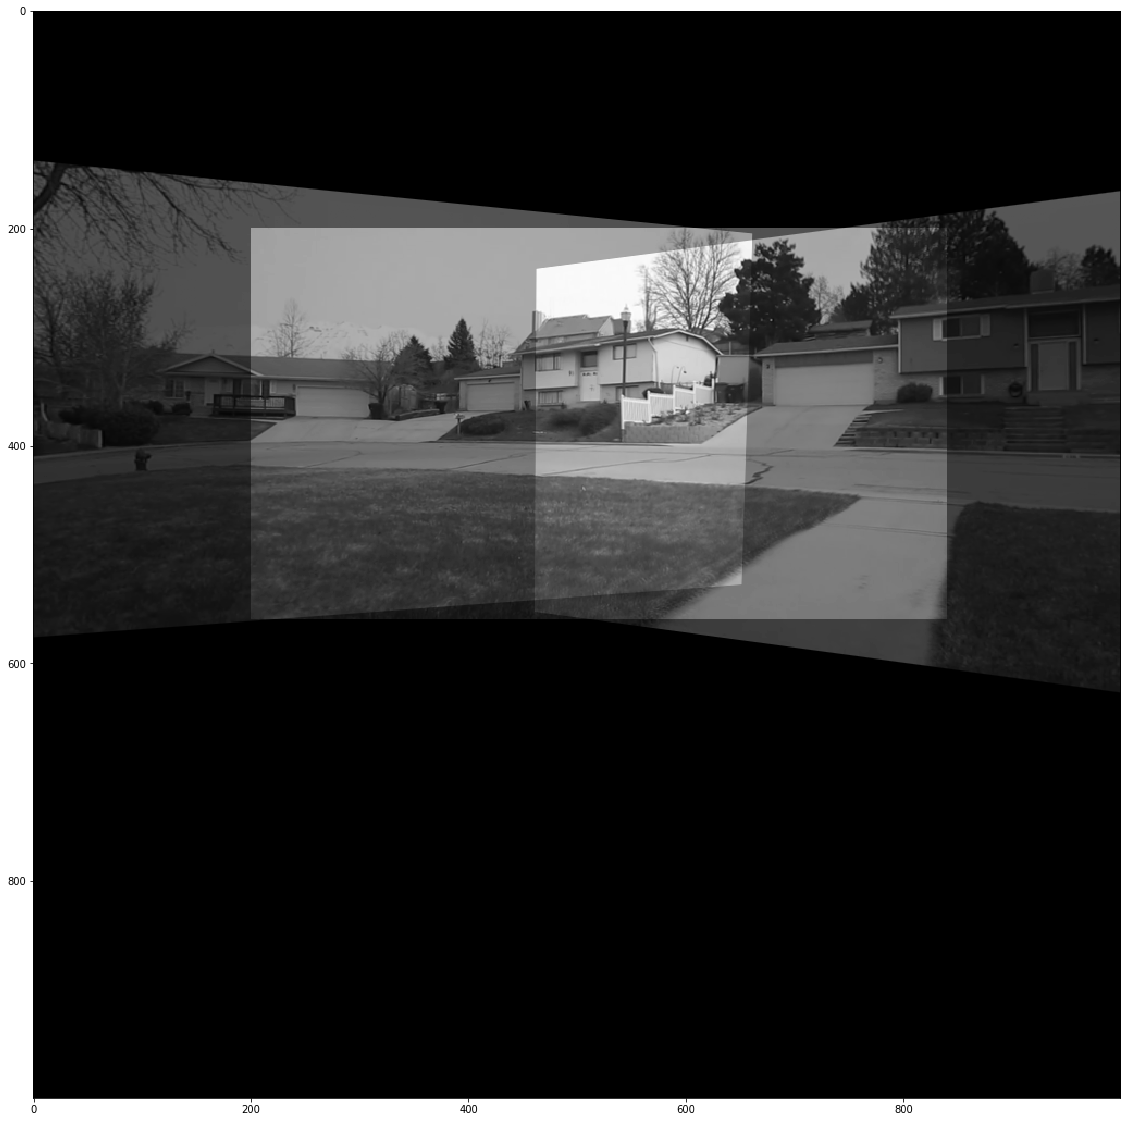

In [22]:
compute_mosaic(img1,img2,img3)